#   Forecasting PV(Photovoltaic) System Power Generation

### Data Science + IoT Project

## Table of contents
* [Introduction: Problem](#introduction)
* [Data Wrangling & EDA](#data)
- [Data Transformation](#DataTransformation)
  + [Stationarity](#stationarity)
  + [Denoising](#denoising)
- [Modeling](#modeling)
  + [Prediction](#forecast)
* [Results and Discussion](#results)

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from IPython.display import display
from skimage.restoration import denoise_wavelet
from colorsetup import colors, palette
sns.set_palette(palette)
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Introduction: Problem <a name="introduction"></a>

The rise of renewable energy presence in power grids globally necessitates the
need for **accurate solar power prediction** as solar power is unpredictable by
nature. Grid balancing is the matching of supply with demand; the failure to
properly balance load distribution can damage transmission components.
<br>


Predicting solar power generation is crucial for power grid balancing; therefore,
the **archetype of solar power forecasting is a model that is accurate with minimal
negative feedback.**


Standard methods such as weather data are antithetical to this as they are
generalized for an entire location nor, do they possess minimal negative feedback
as weather data is generally available hourly.


Training prediction models with onsite data germane to forecasting, namely,
historical solar power generation and influencing factors, are more accurate and
possess minimal negative feedback if computed frequently.


The goal is to develop short-term power **forecasting models** that can be deployed
onsite.

## Section 1: Data Wrangling & Exploratory Data Analysis<a name="data"></a>

<b>Importing IoT Dataset</b>

In [3]:
df = pd.read_csv("IoT_dataset.csv")
df.columns
df

,DATE_TIME,POWER
0,21-04-2021 23:30,0.0
1,21-04-2021 23:45,0.0
2,22-04-2021 00:00,0.0
3,22-04-2021 00:15,0.0
4,22-04-2021 00:30,0.0
...,...,...
659,28-04-2021 22:15,0.0
660,29-04-2021 06:15,0.0
661,29-04-2021 06:30,0.0
662,29-04-2021 06:45,0.0


In [4]:
df['DATE_TIME']= pd.to_datetime(df['DATE_TIME'],format='%d-%m-%Y %H:%M')

In [5]:
df.dtypes

DATE_TIME    datetime64[ns]
POWER               float64
dtype: object

## Setting Index 
For time series data manipulation, we'll set the the DATE_TIME column as the index using the Pandas DateTime Index.

In [6]:
df.set_index('DATE_TIME', inplace=True)

In [7]:
df.index

DatetimeIndex(['2021-04-21 23:30:00', '2021-04-21 23:45:00',
               '2021-04-22 00:00:00', '2021-04-22 00:15:00',
               '2021-04-22 00:30:00', '2021-04-22 00:45:00',
               '2021-04-22 01:00:00', '2021-04-22 01:15:00',
               '2021-04-22 01:30:00', '2021-04-22 01:45:00',
               ...
               '2021-04-28 21:00:00', '2021-04-28 21:15:00',
               '2021-04-28 21:30:00', '2021-04-28 21:45:00',
               '2021-04-28 22:00:00', '2021-04-28 22:15:00',
               '2021-04-29 06:15:00', '2021-04-29 06:30:00',
               '2021-04-29 06:45:00', '2021-04-29 07:00:00'],
              dtype='datetime64[ns]', name='DATE_TIME', length=664, freq=None)

The 'DatetimeIndex' is a different from the ordinary index and it offers more functionality for time series data wrangling.

The output indicates the days of the month we're working with and the week of the year.

<b> Upscaling time series on an hourly basis.<b>

In [8]:
df['POWER'] = df['POWER'].resample('H').mean()

In [9]:
# Dropping empty rows
df = df.dropna()

In [10]:
df.head()

,POWER
DATE_TIME,
2021-04-22 00:00:00,0.0
2021-04-22 01:00:00,0.0
2021-04-22 02:00:00,0.0
2021-04-22 03:00:00,0.0
2021-04-22 04:00:00,0.0


### Plotting Time Series Data

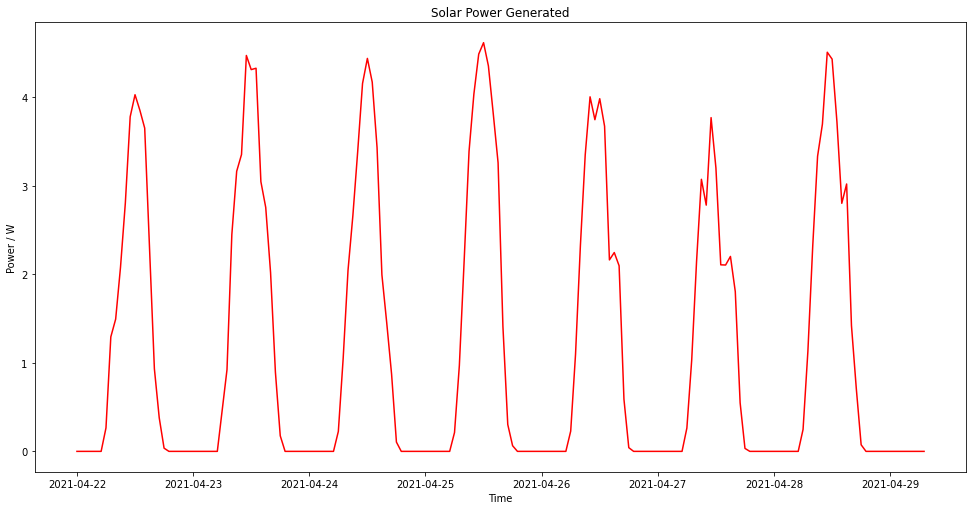

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(16.7, 8.27)
ax.set(xlabel='Time', ylabel='Power / W', title='Solar Power Generated')
sns.lineplot(data = df, x = 'DATE_TIME', y='POWER', color = 'red' );

Now that we have prepared our data. We'll now proceed towards towards modeling our time series data.

## Section 2: Data Transformation<a name="DataTransformation"></a>

The dataset must be stationary in order to train our forecasting models. We'll apply a transformation to the non stationary time series to make it stationary.<br>
A stationary time series is what we're going to be building  our models on. A stationary time series has the following properties:<br>
<ol>
    <li> No systematic change in mean<br>
    <li> No systematic change in variation
        <li> No periodic fluctuations
            </ol>

## 1. Decomposition

Time Series data can be decomposed into two categories:
<b>
    
1.ADDITIVE<br>
2.MULTIPLICATIVE</b>

Additive time Series : $O_{t} = T_{t} + S_{t} + R_{t}$ 

Multiplicative time Series : $O_{t} = T_{t} * S_{t} * R_{t}$ 


Where,<br>
$O_{t}$ is the output   
$T_{t}$ is the trend  
$S_{t}$ is the seasonality  
$R_{t}$ is the residual  
$_t$ is a variable representing a particular point in time 

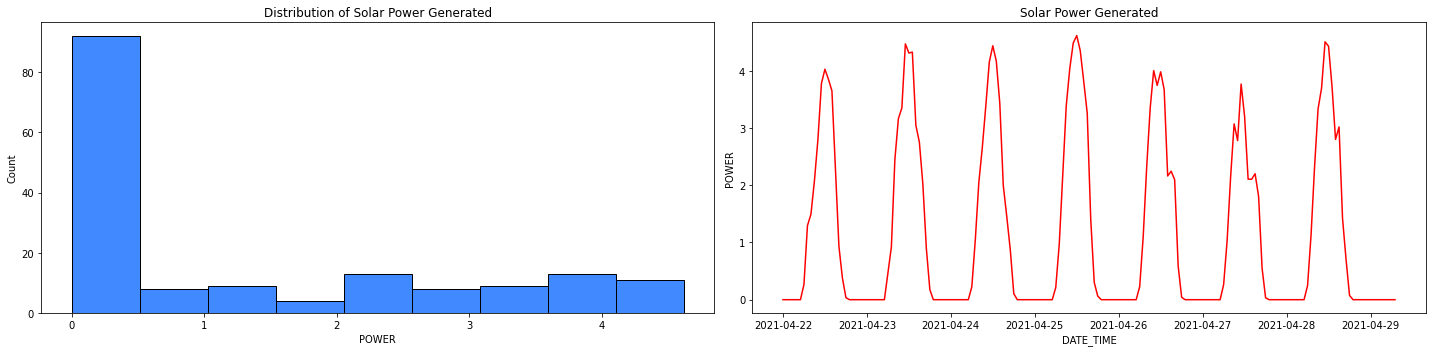

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (20,5))
sns.histplot(df['POWER'],ax = ax1);
sns.lineplot(data = df, x = 'DATE_TIME', y='POWER', color = 'red', ax = ax2 );
ax1.set(title='Distribution of Solar Power Generated');
ax2.set(title = 'Solar Power Generated');
fig.tight_layout()

Visually, there's no trend in our data but it has strong seasonality as the solar panel generates power during the day and peaks at midday when the intensity of the sun is the strongest. 

Our TS is additive in nature. We'll find out the right period to remove the seasonality.

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts_decomposition = seasonal_decompose(x=df['POWER'], model='additive', period=24)
estimated_trend = ts_decomposition.trend
estimated_seasonal = ts_decomposition.seasonal
estimated_residual = ts_decomposition.resid

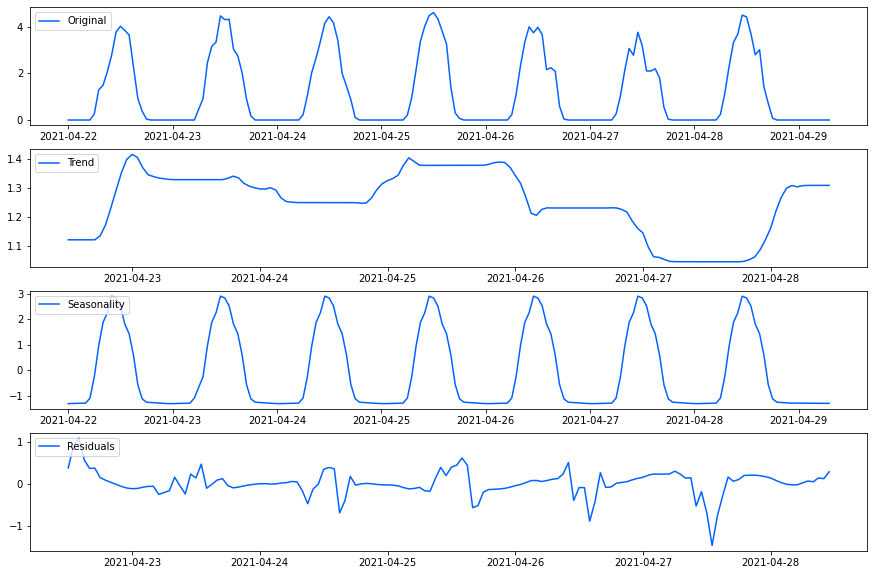

In [14]:
fig, axes = plt.subplots(4, 1)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(df['POWER'], label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

A period of 24 captures the seasonality and trend. While there is some deviation in the beginning, it appears to be built in and barring that the residuals are fairly stationary. 

Let's take the seasonal difference of our data to remove the seasonality

In [15]:
df['lag_24h'] = df.POWER.shift(24)
df['seasonal_diff'] = df.POWER - df['lag_24h']

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


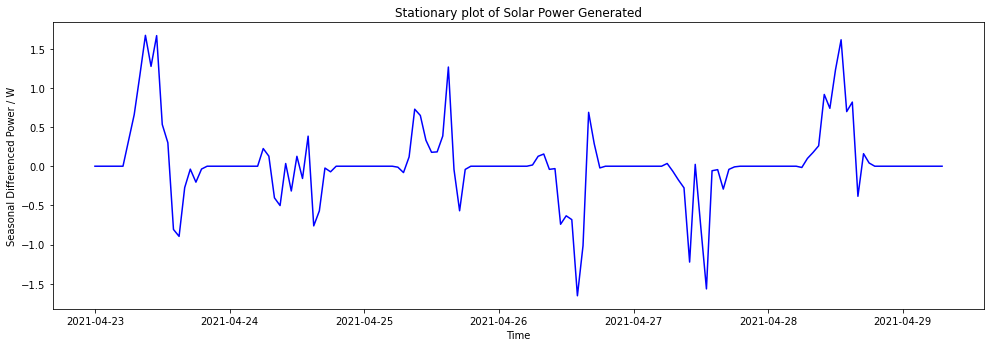

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(16.7, 5.27)
ax.set(xlabel='Time', ylabel='Seasonal Differenced Power / W', title='Stationary plot of Solar Power Generated')
sns.lineplot(data = df, x = 'DATE_TIME', y='seasonal_diff', color = 'blue' );

We'll verify stationarity using the Augmented Dickey-Fuller Test: a statistical procedure to check whether a time series is stationary.

Like any statistical test, the ADF test has a null and alternative hypothesis.


<b>Null hypothesis</b>: the series is nonstationary.<br>
<b>Alternative hypothesis:</b>the series is stationary.

Let's build a function to compute the ADF statistic.

In [16]:
def adf_test(ts_data):
    dftest = ts.adfuller(ts_data,)
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [17]:
adf_test(df['seasonal_diff'].dropna())

Test Statistic           -4.429873
p-value                   0.000263
Lags Used                 2.000000
Observations Used       140.000000
Critical Value (1%)      -3.477945
Critical Value (5%)      -2.882416
Critical Value (10%)     -2.577902
dtype: float64


The more negative the Test Statistic, the more likely that the time series is stationary. The p-value tells us how confident we can be about our Test Statistic. In this case, our Test Statistic is fairly negative and our p-value is close to zero.

<b>Therefore, we can infer that our seasonal differenced time series data is stationary.</b>

## 2. Smoothing: Denoising

Any data collection process is subject to noise and it can obscure useful patterns. Smoothing is used to extract those patterns. 

WAVELET TRANSFORM

In [18]:
df1 = df.copy()

In [19]:
df['seasonal_diff'] = denoise_wavelet(df['seasonal_diff'], wavelet= 'sym8', mode = 'hard', wavelet_levels = 3, method = 'BayesShrink', rescale_sigma = 'False')

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


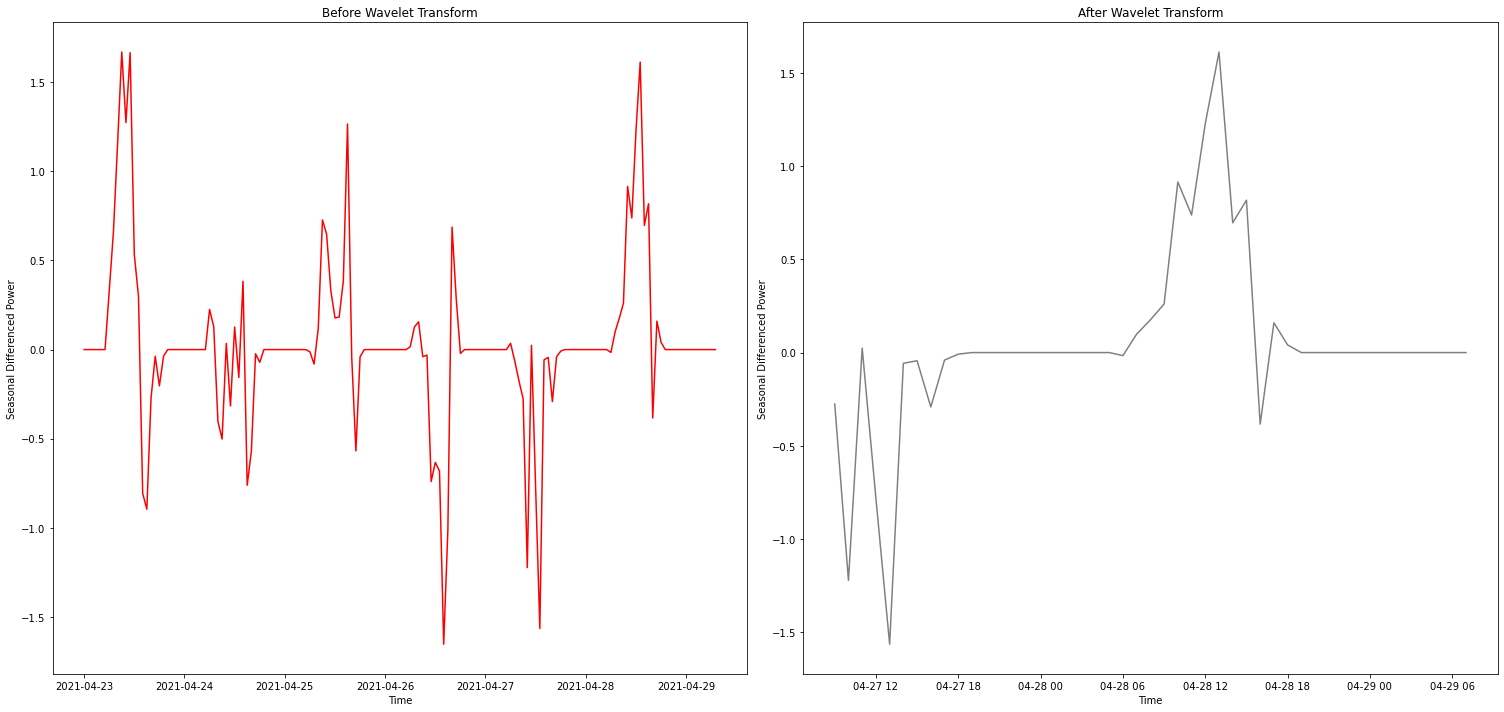

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (21,10))
sns.lineplot(data = df1, x = 'DATE_TIME', y='seasonal_diff', color = 'red', ax = ax1 );
sns.lineplot(data = df, x = 'DATE_TIME', y='seasonal_diff', color = 'grey', ax = ax2 );
ax1.set(title = 'Before Wavelet Transform', ylabel = 'Seasonal Differenced Power', xlabel = 'Time');
ax2.set(title = 'After Wavelet Transform', ylabel = 'Seasonal Differenced Power', xlabel = 'Time');
plt.tight_layout()

We have removed some noise from our data, we will now proceed towards modelling.

# Section 3: Modeling<a name="modeling"></a>

# Forecasting: SARIMA 

Now, we have to choose the values of p, d, q, P, D, and Q.
We enlist the help of the ACF (Autocorrelation Function) and PACF(Partial Autocorrelation function) to compute them

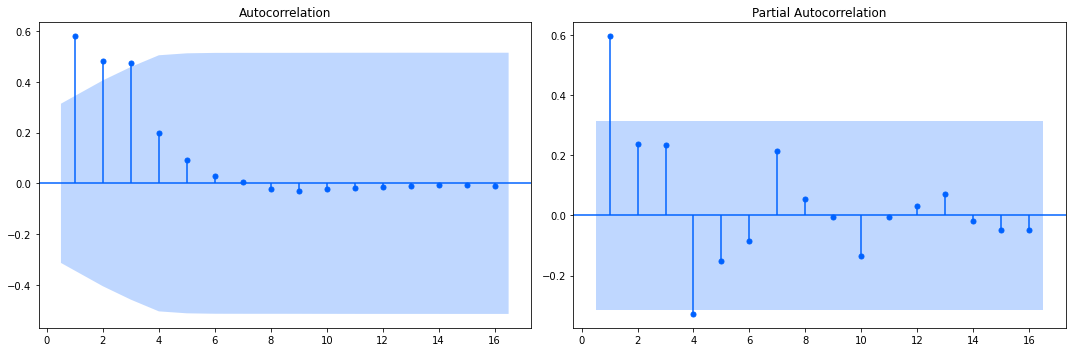

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
sm.tsa.graphics.plot_acf(df['seasonal_diff'].dropna(), ax = ax1,zero=False)
sm.tsa.graphics.plot_pacf(df['seasonal_diff'].dropna(),ax = ax2,zero = False);
plt.tight_layout()

It appears to be an AR(2) Model with seasonal differencing due to the osicallatory nature of the ACF graph.
We'll iterate through a range of expected values of p,d,q, P, D, and Q and use the following measurement metrics to choose the SARIMA Model.
<b>
    <ul>
        <li> AIC: Akaike Information Criteria
            <li> BIC: Bayesian Information Criteria
    </ul>
 </b>
 The ACF and PACF plots are very objective measures of quality. The AIC & BIC metrics are more numerical measures of quality.
 

### Inference from ACF and PACF

SARIMA has 7 parameters


 p: Range from 0 to 4<br>
 q: Range from 0 to 3<br>
 d: Range from 0 to 1<br>
 P & Q: Range from 0 to 1<br>
 We have seasonal differenced our dataset once as well, so we'll set D = 1.<br>
 m = 24

Splitting data into train and test set

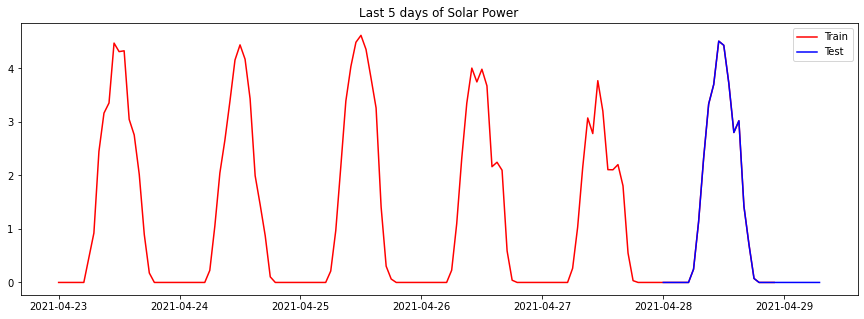

In [22]:
train=df['POWER']['2021-04-23':'2021-04-28']
test=df['POWER']['2021-04-28':]
plt.figure(figsize=(15,5));
plt.plot(train,label='Train',color='red');
plt.plot(test,label='Test',color='blue');
plt.title('Last 5 days of Solar Power');
plt.legend();
plt.show();

In [23]:
sarima_model = pm.auto_arima(train,
                         start_p=0,d=0,start_q=0,
                         max_p=4,max_d=1,max_q=3,
                         start_P=0,D=1,start_Q=0,
                         max_P=1,max_D=1,max_Q=1,m=24,
                         seasonal=True,
                         error_action='warn',trace=True,
                         supress_warning=True,stepwise=True,
                         random_state=20,n_fits=1)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=142.703, Time=0.11 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=86.735, Time=0.66 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=1.49 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=140.713, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=107.218, Time=0.10 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=2.37 sec
 ARIMA(1,0,0)(0,1,1)[24] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(0,0,0)(1,1,0)[24] intercept   : AIC=128.549, Time=0.30 sec
 ARIMA(2,0,0)(1,1,0)[24] intercept   : AIC=88.726, Time=0.58 sec
 ARIMA(1,0,1)(1,1,0)[24] intercept   : AIC=88.720, Time=0.94 sec
 ARIMA(0,0,1)(1,1,0)[24] intercept   : AIC=93.301, Time=0.49 sec
 ARIMA(2,0,1)(1,1,0)[24] intercept   : AIC=89.382, Time=1.17 sec
 ARIMA(1,0,0)(1,1,0)[24]             : AIC=84.856, Time=0.30 sec
 ARIMA(1,0,0)(0,1,0)[24]             : AIC=105.221, Time=0.07 sec
 ARIMA(1,0,0)(1,1,1)[24]             : AIC=inf, Tim

In [24]:
print('order: ',sarima_model.order)
print('seasonal order: ',sarima_model.seasonal_order)

order:  (1, 0, 0)
seasonal order:  (1, 1, 0, 24)


In [25]:
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  142
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 24)   Log Likelihood                 -39.428
Date:                            Thu, 13 May 2021   AIC                             84.856
Time:                                    09:12:36   BIC                             93.168
Sample:                                         0   HQIC                            88.231
                                            - 142                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5572      0.048     11.542      0.000       0.463       0.652
ar.S.L24      -0.4423      0.067     -6.631      0.000      -0.573      -0.312
sigma2         0.1089      0.008     12.847      0.000       0.092       0.126
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               111.43
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.22   Skew:                            -1.33
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### We have trained our forecasting model.
## Forecasting for the next day

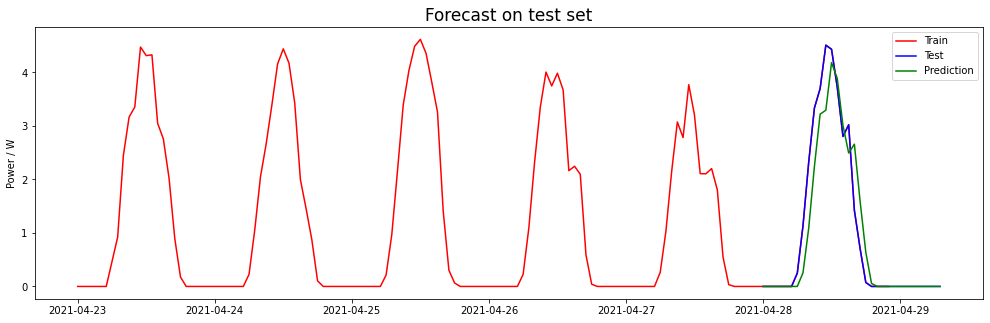

In [26]:
prediction=pd.DataFrame(sarima_model.predict(n_periods=24),index=test.index)
prediction.columns=['predicted_power']

plt.figure(figsize=(17,5))
plt.plot(train,label='Train',color='red')
plt.plot(test,label='Test',color='blue')
plt.plot(prediction,label='Prediction',color='green')
plt.legend()
plt.title('Forecast on test set',size=17)
plt.ylabel('Power / W');

In [27]:
prediction

,predicted_power
DATE_TIME,
2021-04-28 00:00:00,-1.551580e-27
2021-04-28 01:00:00,-1.038342e-27
2021-04-28 02:00:00,-6.388324e-28
2021-04-28 03:00:00,-9.771249e-28
2021-04-28 04:00:00,-2.568033e-27
2021-04-28 05:00:00,-1.327011e-27
2021-04-28 06:00:00,3.215564e-19
2021-04-28 07:00:00,2.546201e-01
2021-04-28 08:00:00,1.088488e+00


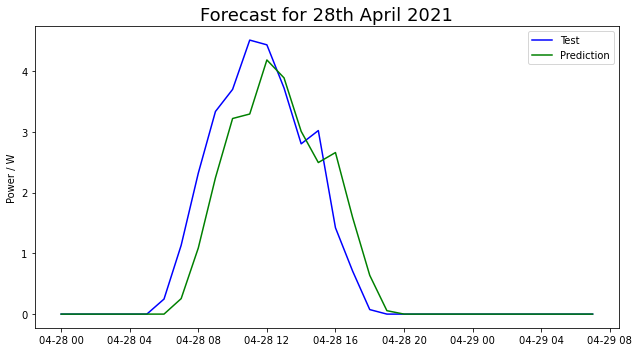

In [28]:
prediction.index= pd.to_datetime(prediction.index, format='%d-%m-%')

plt.figure(figsize=(9,5))
plt.plot(test,label='Test',color='blue')
plt.plot(prediction,label='Prediction',color='green')
plt.legend()
plt.title('Forecast for 28th April 2021',size=18)
plt.ylabel('Power / W');
# plt.xticks(color='w');
plt.tight_layout()

In [29]:
sarima_mse = mean_squared_error(test,prediction)
sarima_mse

0.3453905280727309

## Results and Discussion <a name="results"></a>

Our analysis shows that the PV power generated is seasonal with no trend implying non stationarity. The dataset had 15 minute intervals which were upscaled to 1 hour intervals.The time series data was then made stationary using seasonal differencing and tested using the Augmented Dickey-Fuller test.<br>
Additionally, we smoothed the time series data using a wavelet transform to remove high frequency noise components which do not contain any useful information.<br>

The ACF and PACF plots were used to objectively determine the range of SARIMA parameters. The last 5 days of the dataset were used to train the SARIMA model to forecast the power generated.
<br>
Furthermore, deep learning algorithms like RNN & LSTM can be used to improve accuracy with significant increases in model fit time. 